
<p>

<font color="#306998"><h1><center>Python Labs</center></h1></font></p>
<p></p><h1><center>Introduction to QuantLib-Python</center></h1><br/>
<center><b>Kannan Singaravelu</b></center>
<center>kannan.singaravelu@fitchlearning.com</center>



<h2 id="QuantLib-Python">QuantLib-Python<a class="anchor-link" href="#QuantLib-Python">¶</a></h2><p>Over the counter derivatives and structured products are increasingly getting complex and almost all of the derivatives pricing used today is based on numerical methods. While large institutions have resources to develop and maintain their own state-of-art financial libraries, small players lack such resources.</p>
<p>The QuantLib open-source project was started in the year 2000 with an aim to provide comprehensive software framework for quantitative finance. Originally pioneered by two Italian quants Luigi Ballabio and Ferdinando Ametrano, it is an open source C++ library that provides tools for the valuation of financial instruments. By using <strong>Simplified Wrapper and Interface Generator (SWIG)</strong>, it is possible to use QuantLib from Python.</p>
<p>Today, this has become the go to solutions for all including large institutions. On the flip side it lacks proper doc string (documentation) for Python extension. Also, Python doesn’t have templates. Thus, the SWIG wrappers have to declare separate classes QuoteHandle, YieldTermStructureHandle and so on. We can go back to original syntax in in C++ when there is no directly documentation available in Python.</p>
<p>We will go through the basic of <code>QuantLib-Python</code> library and will also price European options. We will also demonstrate other evaluation process such as Heston and MonteCarlo engine in pricing these options.</p>


In [ ]:

# ! pip install QuantLib-Python



In [1]:

# import required libarries
import pandas as pd
import numpy as np

from tabulate import tabulate
from QuantLib import *

# Import the matplotlib and cufflinks libraries for visualization
import cufflinks as cf
cf.set_config_file(offline=True)



In [2]:

QuantLib.__version__



'1.25'


<h2 id="Structure-of-QuantLib">Structure of QuantLib<a class="anchor-link" href="#Structure-of-QuantLib">¶</a></h2><p>Price of any derivative, be it a plain-vanilla option or a structured product, depends on the following inputs and QuantLib has effectively designed classes for such inputs as depicted in the following chart.</p>



<p>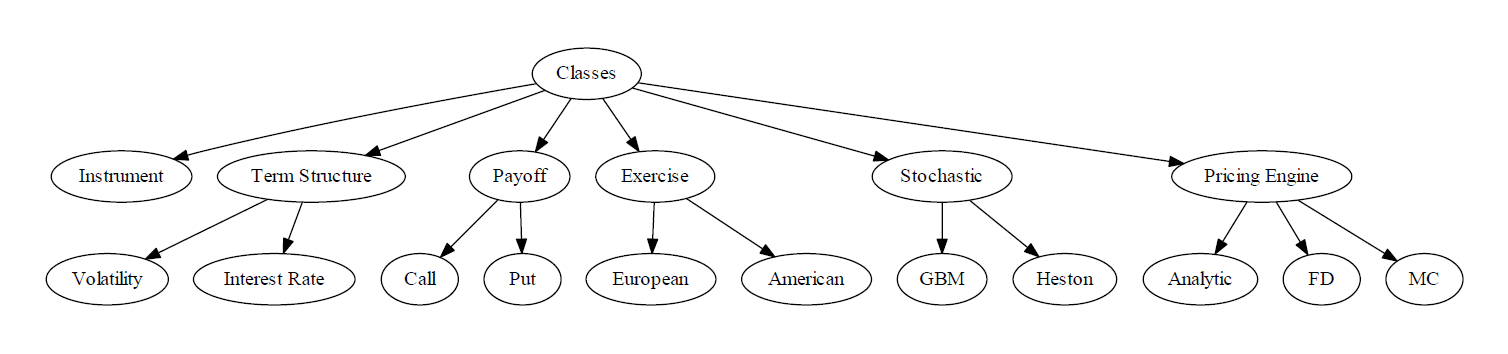</p>
<center><b>Representation of key classes of QuantLib Python</b></center>



<h3 id="QuantLib-Basics">QuantLib Basics<a class="anchor-link" href="#QuantLib-Basics">¶</a></h3><p>Date, Period, Calender and Schedule Class are the basic construct that will be used throughout the in creation of instruments, models and termstructure.</p>
<h4 id="Date-Class">Date Class<a class="anchor-link" href="#Date-Class">¶</a></h4><p>The Date object can be created using the constructor as Date (day, month, year). This format is different from the Python datetime object.</p>


In [3]:

# Date object
date = Date(11,5,2020)

print(date)



May 11th, 2020


In [4]:

# Use month(), dayOfMonth(), year() and weekday() methods to access the Date object

print(date.month())
print(date.dayOfMonth())

print(date.year())
print(date.dayOfYear())

print(date.weekday() == Monday)



5
11
2020
132
True



<p>Date objects can perform arithmetic and logical operations. Periods are denoted using the <strong>Period Class</strong>. Period object is called using <code>Period(num_periods, period_type)</code> where num_periods (number of periods) is an integer and period_type can be Weeks, Months and Years.</p>
<p>The Date objects will be used to set instruments dates such as valuation, issuance and expiry dates while Period objects are used to set the tenors, coupon payments dates and in constructing the payment schedules.</p>


In [5]:

# Arithmetic operations
print('Add a day   :', date + 1)
print('Add a Month :', date + Period(1, Months))
print('Add a Year  :', date + Period(1, Years))

# Logical operations
print(date == Date(4, 5, 2020))
print(date > Date(3, 5, 2020))



Add a day   : May 12th, 2020
Add a Month : June 11th, 2020
Add a Year  : May 11th, 2021
False
True



<h4 id="Calender-Class">Calender Class<a class="anchor-link" href="#Calender-Class">¶</a></h4>



<p>Arithmetic operation in Date object above did not take holidays into account. But we need to take into consideration the holidays for valuation of some securities like bonds for payment of interest and principal. The Calendar class implements this functionality for all the major exchanges.</p>
<p>Methods: addHoliday, removeHoliday, bussinessDaysBetween are few methods associated. More than one calender holidays is also possible using JointCalendar class.</p>


In [ ]:

# Calender class functions
us_calendar = UnitedStates()
india_calendar = India()

period = Period(50, Days)
us_date = us_calendar.advance(date, period)
india_date = india_calendar.advance(date, period)



In [ ]:

# Arithmetic operations using Calender Class
print('Add 50 days          :', date + Period(50, Days))
print('Add 50 days in US    :', us_date)
print('Add 50 days in India :', india_date)



In [ ]:

us_busdays = us_calendar.businessDaysBetween(date, us_date)
india_busdays = india_calendar.businessDaysBetween(date, india_date)



In [ ]:

# Print business days
print ("Business days US:", us_busdays)
print ("Business days India:", india_busdays)



In [ ]:

# Joint calendar class to combine two calendars
joint_calendar = JointCalendar(us_calendar, india_calendar)

print("Add 50 days in US-India:", joint_calendar.advance(date, period))




<h4 id="Schedule-Class">Schedule Class<a class="anchor-link" href="#Schedule-Class">¶</a></h4><p>The Schedule object is necessary in creating coupon or call schedules. Schedule object has the following construct:</p>
<p><code>Schedule(effectiveDate, terminationDate, tenor, calendar, convention, terminationDateConvention, rule, endOfMonth, firstDate=Date(), nextToLastDate = Date ())</code></p>
<p>The two optional parameters firstDate and nextToLastDate along with a combination of forward or backward date generation rule can be used to generate short or long stub payments at the front or back end of the schedule.</p>


In [ ]:

# Schedule object construction
effective_date = Date(1, 1, 2020)
termination_date = Date(1, 12, 2020)
tenor = Period(Monthly)
calendar = UnitedStates()
business_convention = Following
termination_business_convention = Following
date_generation = DateGeneration.Forward
end_of_month = False



In [ ]:

schedule = Schedule(effective_date,
                    termination_date,
                    tenor,
                    calendar,
                    business_convention,
                    termination_business_convention,
                    date_generation,
                    end_of_month)



In [ ]:

for i, d in enumerate(schedule):
    print(i+1, d)




<h2 id="Pricing-a-European-Option">Pricing a European Option<a class="anchor-link" href="#Pricing-a-European-Option">¶</a></h2><p>We will now price a textbook example of an European Option. As a first step, we will get the specification of the contract: the payoff (call option with strike 100) and its exercise date (12 months from today).</p>



<h3 id="Setup">Setup<a class="anchor-link" href="#Setup">¶</a></h3>



<p>Set up the global evaluation date to today</p>


In [ ]:

# Set US calendar
us_calendar = UnitedStates()

# Setting valuation date to today
today = Date(11,5,2020)
Settings.instance().evaluationDate = today




<p>Building the option requires only the specification of its contract: the payoff and its exercise.</p>



<h3 id="Instrument">Instrument<a class="anchor-link" href="#Instrument">¶</a></h3>


In [ ]:

# Define option instrument
option = EuropeanOption(PlainVanillaPayoff(Option.Call, 100), EuropeanExercise(Date(11,5,2021)))




<h3 id="Pricing-Methods">Pricing Methods<a class="anchor-link" href="#Pricing-Methods">¶</a></h3><p>The different pricing methods are implemented as pricing engines holding the required market data. First we’ll use is the one encapsulating the analytic Black-Scholes formula, followed by Heston and Monte Carlo methods.</p>
<p>Next, we collect the quoted market data and also assume flat risk-free rate and volatility so that they can be expressed by <code>SimpleQuote</code> instances.</p>
<p>We will now pass the market data: price : 100, risk-free rate: 5% and sigma: 20%.</p>


In [ ]:

# Underlying Price
u = SimpleQuote(100)

# Risk-free Rate
r = SimpleQuote(0.05)

# Sigma 
sigma = SimpleQuote(.20)

# Build flat curves and volatility
riskFreeCurve = FlatForward(0, TARGET(), QuoteHandle(r), Actual360()) 
volatility = BlackConstantVol(0, TARGET(), QuoteHandle(sigma), Actual360()) # Target tells what days are holidays




<p>Let's now build the pricing engine by encapsulating the market data in a Black-Scholes process</p>


In [ ]:

process = BlackScholesProcess(QuoteHandle(u), 
                              YieldTermStructureHandle(riskFreeCurve),
                              BlackVolTermStructureHandle(volatility))

# Once we have the process, we can finally use it to build the engine…
engine = AnalyticEuropeanEngine(process)




<p>We will now set this engine to option for evaluation</p>


In [ ]:

option.setPricingEngine(engine)



In [ ]:

header = ['OptionPrice', 'Delta', 'Gamma', 'Theta', 'Vega']
table = [[option.NPV(), option.delta(), option.gamma(), option.thetaPerDay(), option.vega()]]



In [ ]:

print(tabulate(table,header))




<h4 id="Market-Data-Changes">Market Data Changes<a class="anchor-link" href="#Market-Data-Changes">¶</a></h4><p>Let's now change the market data to see its impact on option pricing. As the market data are stored in Quote instances, we dont't need to explicitly recalculate the option again. We'll simply retrive the update value.</p>


In [ ]:

# let's change the underlying price
u.setValue(120)



In [ ]:

header1 = ['OptionPrice', 'Delta', 'Gamma', 'Theta', 'Vega']
table1 = [[option.NPV(), option.delta(), option.gamma(), option.thetaPerDay(), option.vega()]]

print(tabulate(table1,header1))



In [ ]:

# let's change the sigma value
sigma.setValue(.25)



In [ ]:

header2 = ['OptionPrice', 'Delta', 'Gamma', 'Theta', 'Vega']
table2 = [[option.NPV(), option.delta(), option.gamma(), option.thetaPerDay(), option.vega()]]

print(tabulate(table2,header2))



In [ ]:

# Import cufflinks library for visualization
import cufflinks as cf
cf.set_config_file(offline=True)



In [ ]:

df = pd.DataFrame({'Sep-2020': [None]*400, 'Dec-2020': [None]*400, 
                   'Mar-2021': [None]*400, 'May-2021': [None]*400}, index=np.linspace(50., 150., 400))



In [ ]:

# Sep-2020
Settings.instance().evaluationDate = Date(11, 9, 2020)

ys = []
for x in df.index:
    u.setValue(x)
    ys.append(option.NPV())
df['Sep-2020'] = ys
print (option.NPV())



In [ ]:

# DEc-2020
Settings.instance().evaluationDate = Date(11, 12, 2020)

ys1 = []
for x in df.index:
    u.setValue(x)
    ys1.append(option.NPV())
df['Dec-2020'] = ys1
print (option.NPV())



In [ ]:

# Mar 2021
Settings.instance().evaluationDate = Date(11, 3, 2021)

ys2 = []
for x in df.index:
    u.setValue(x)
    ys2.append(option.NPV())
df['Mar-2021'] = ys2
print (option.NPV())



In [ ]:

# May 2021
Settings.instance().evaluationDate = Date(9, 5, 2021)

ys3 = []
for x in df.index:
    u.setValue(x)
    ys3.append(option.NPV())
df['May-2021'] = ys3
print (option.NPV())



In [ ]:

df[['Sep-2020', 'Dec-2020', 'Mar-2021', 'May-2021']].iplot(kind='scatter', title='Option Value')




<h2 id="Pricing-AAPL-Option">Pricing AAPL Option<a class="anchor-link" href="#Pricing-AAPL-Option">¶</a></h2><p>Let's price a European call option for AAPL with a strike price of 310 maturing on 18th Jun,2021. The spot price be 310 with volatility of the underlying stock at 35%, and a dividend yield of 1.05%.</p>
<p>Let’s value this option as of 11th May, 2020.</p>
<p><a href="https://finance.yahoo.com/quote/AAPL/options?date=1623974400&amp;p=AAPL">https://finance.yahoo.com/quote/AAPL/options?date=1623974400&amp;p=AAPL</a></p>


In [ ]:

maturity_date = Date(18, 6, 2021)
spot_price = 315.
strike_price = 310.
volatility = 0.35
dividend_rate = 0.0105

option_type = Option.Call
risk_free_rate = 0.001

day_count = Actual365Fixed()
calendar = UnitedStates()

calculation_date = Date(11, 5, 2020)
Settings.instance().evaluationDate = calculation_date




<p>We'll now construct the European option now.</p>


In [ ]:

payoff = PlainVanillaPayoff(option_type, strike_price)
exercise = EuropeanExercise(maturity_date) #AmericanExercise()

# define instrument
aapl_option = EuropeanOption(payoff, exercise)




<p>Next, we construct the Black-Scholes-Merton stochastic process</p>


In [ ]:

spot_handle = QuoteHandle(SimpleQuote(spot_price))

flat_ts = YieldTermStructureHandle(
    FlatForward(calculation_date, risk_free_rate, day_count))

dividend_yield = YieldTermStructureHandle(
    FlatForward(calculation_date, dividend_rate, day_count))

flat_vol_ts = BlackVolTermStructureHandle(
    BlackConstantVol(calculation_date, calendar, volatility, day_count))

bsm_process = BlackScholesMertonProcess(spot_handle, dividend_yield, flat_ts, flat_vol_ts)




<p>Now, we compute option price using AnalyticEuropeanEngine and set this engine to option for evaluation</p>


In [ ]:

bsm_engine = AnalyticEuropeanEngine(bsm_process) #MCAmericanEngine()
aapl_option.setPricingEngine(bsm_engine)



In [ ]:

header3 = ['OptionPrice', 'Delta', 'Gamma', 'Theta', 'Vega']
table3 = [[aapl_option.NPV(), aapl_option.delta(), aapl_option.gamma(), aapl_option.thetaPerDay(), aapl_option.vega()]]

print(tabulate(table3,header3))




<h2 id="The-Barrier-Option">The Barrier Option<a class="anchor-link" href="#The-Barrier-Option">¶</a></h2><p>We will now price a European Up-and-Out Call Option. As a first step, we will get the specification of the contract: Strike 100, Barrier 150, Rebate 50, Exercise date 4 years from now.</p>



<p>Set up the global evaluation date to today</p>


In [ ]:

today = Date(28,February,2020)
Settings.instance().evaluationDate = today



In [ ]:

option = BarrierOption(Barrier.UpOut, 150.0, 50.0, 
                       PlainVanillaPayoff(Option.Call, 100.0), EuropeanExercise(Date(29, February, 2024)))




<p>We will now pass the market data: spot price : 100, risk-free rate: 1% and sigma: 30% and build the term structure of volatility and interest rate.</p>


In [ ]:

# Underlying Price
u = SimpleQuote(100)

# Risk-free Rate
r = SimpleQuote(0.01)

# Sigma 
sigma = SimpleQuote(0.30)

# Build flat curves and volatility
riskFreeCurve = FlatForward(0, TARGET(), QuoteHandle(r), Actual360())
volatility = BlackConstantVol(0, TARGET(), QuoteHandle(sigma), Actual360())




<h4 id="Model--and-Pricing-Engine">Model  and Pricing Engine<a class="anchor-link" href="#Model--and-Pricing-Engine">¶</a></h4><p>Let's now build the pricing engine by encapsulating the market data in a Black-Scholes process.</p>


In [ ]:

process = BlackScholesProcess(QuoteHandle(u), 
                              YieldTermStructureHandle(riskFreeCurve), 
                              BlackVolTermStructureHandle(volatility))

# Now, we build the engine (based on an analytic formula) and set it to the option for evaluation
option.setPricingEngine(AnalyticBarrierEngine(process))



In [ ]:

# Option Value
option.NPV()




<h3 id="Numerical-Calculation-of-Greeks">Numerical Calculation of Greeks<a class="anchor-link" href="#Numerical-Calculation-of-Greeks">¶</a></h3>



<p>The QuantLib framework of instrument class makes it easier to set the relevant market data to price the options with new quote and approximate the Greeks using numerical differentiation.</p>
<p></p><center><h3>Numerical Calculation</h3></center>
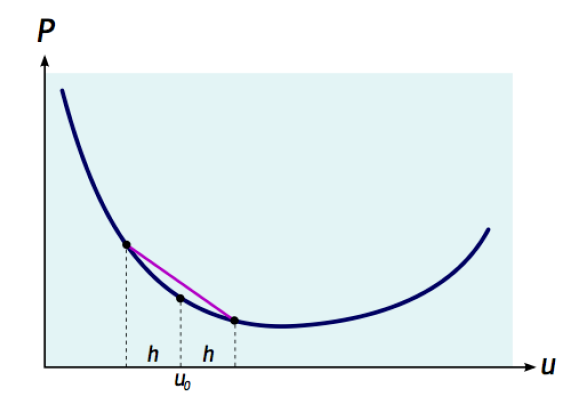



<h4 id="Market-Data-Changes">Market Data Changes<a class="anchor-link" href="#Market-Data-Changes">¶</a></h4><p>Let's now change the market data to get new option pricing. As the market data are stored in Quote instances, we dont't need to explicitly recalculate the option again. We'll simply retrive the update value.</p>


In [ ]:

# Set initial value and define h
u0 = u.value(); h=0.01
P0 = option.NPV()



In [ ]:

# Bump up the price by h
u.setValue(u0+h)
P_plus = option.NPV()



In [ ]:

# Bump down the price by h
u.setValue(u0-h)
P_minus = option.NPV() 



In [ ]:

# Set the price back to its current value
u.setValue(u0)




<h4 id="Calculation-ofGreeks:-Delta,-Gamma,-Rho,-Vega,-Theta">Calculation ofGreeks: Delta, Gamma, Rho, Vega, Theta<a class="anchor-link" href="#Calculation-ofGreeks:-Delta,-Gamma,-Rho,-Vega,-Theta">¶</a></h4>


In [ ]:

delta = (P_plus - P_minus)/(2*h)
gamma = (P_plus - 2*P0 + P_minus)/(h*h)



In [ ]:

r0 = r.value(); h1 = 0.0001
r.setValue(r0+h); P_plus = option.NPV()
r.setValue(r0)



In [ ]:

# Rho
rho = (P_plus - P0)/h1



In [ ]:

sigma0 = sigma.value() ; h = 0.0001
sigma.setValue(sigma0+h) ; P_plus = option.NPV()
sigma.setValue(sigma0)



In [ ]:

# Vega
vega = (P_plus - P0)/h



In [ ]:

Settings.instance().evaluationDate = today+1
P1 = option.NPV()
h = 1.0/365



In [ ]:

# Theta
theta = (P1-P0)/h



In [ ]:

header = ['OptionPrice', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[P0, delta, gamma, theta, vega, rho]]



In [ ]:

print(tabulate(table,header))




<h1 id="References">References<a class="anchor-link" href="#References">¶</a></h1><ul>
<li><p>Goutham Balaraman and Luigi Ballabio (2019), QuantLib Python Cookbook: Hands-on Quantitative Finance in Python</p>
</li>
<li><p>QuantLib-Python installation on windows: <a href="https://www.quantlib.org/install/windows-python.shtml">https://www.quantlib.org/install/windows-python.shtml</a></p>
</li>
<li><p>QuantLib Documentation: <a href="https://quantlib-python-docs.readthedocs.io/en/latest/index.html">https://quantlib-python-docs.readthedocs.io/en/latest/index.html</a></p>
</li>
<li><p>QuantLib GitHub Resources:  <a href="https://github.com/lballabio/QuantLib/blob/master/ql/termstructures/volatility/equityfx/blackconstantvol.hpp">https://github.com/lballabio/QuantLib/blob/master/ql/termstructures/volatility/equityfx/blackconstantvol.hpp</a></p>
</li>
<li><p>Barrier option pricing using QuantLib: <a href="https://medium.com/@kannansingaravelu/how-to-price-barrier-option-using-quantlib-python-ee4b1fff2448">https://medium.com/@kannansingaravelu/how-to-price-barrier-option-using-quantlib-python-ee4b1fff2448</a></p>
</li>
<li><p>Paul Wilmott (2007), Paul Wilmott introduces Quantitative Finance</p>
</li>
</ul>
